# HAND SEGMENTATION via U-net architecture

Using UltimateDataset: 3200 computer generated dataset +  eythdataset + egoHand + hands over face
total around 6000 images

Problem to solve: the model is overfitting on the training dataset, but poorly performing on the benchmark dataset.

## TODO: 
- increase dropout in encoding part, decreasing dropout in decoding part


Images already resized and preprocessed are loaded as zip files on Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip files into 'color' and 'segmented' folders

In [4]:
!unzip -q /content/drive/MyDrive/UltimateDataset/color.zip -d /content/drive/MyDrive/UltimateDataset/color

In [5]:
!unzip -q /content/drive/MyDrive/UltimateDataset/segmented.zip -d /content/drive/MyDrive/UltimateDataset/segmented

Import all needed modules

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np

import os
import glob
import PIL
from PIL import ImageOps
from PIL import Image

import time
from IPython.display import Image, display

from keras.preprocessing.image import load_img, img_to_array, array_to_img

Since the dataset we will use is pretty heavy (ca. 18000 images) we can not load all in its entirety therefore we extend Sequence class of keras to load it when required by batches of size batch_size

Here we prepare the filename list, shuffling it to have more variety between images (otherwise loaded sequentially by similar "hand letter" or similar by dataset content)

Images are already resized in processing

In [7]:
# paths in drive to input and output images
color_folder = '/content/drive/MyDrive/UltimateDataset/color/color'
segmented_folder = '/content/drive/MyDrive/UltimateDataset/segmented/segmented'

print(len(os.listdir(color_folder)))
print(len(os.listdir(segmented_folder)))

7828
7828


In [20]:
img_size = (224, 224) 
num_classes = 1 # 2 classes (hand, non hand) but we just need 1 depth layer to represent a probability between 0 and 1
batch_size = 64 

color_images_path = sorted([os.path.join(color_folder, fname) for fname in os.listdir(color_folder) if fname.endswith(".png") or fname.endswith(".jpg")])
segmented_images_path = sorted([os.path.join(segmented_folder, fname) for fname in os.listdir(segmented_folder) if fname.endswith(".png") or fname.endswith(".jpg")])

# The sorted in above code was for ensuring that the color-segmented pairs were loaded in same order
# I want to shuffle the dataset to destroy correlation between images as dataset is made up of letters of mute sign
# Applying same shuffling to both path lists
from sklearn.utils import shuffle
color_images_path, segmented_images_path = shuffle(color_images_path, segmented_images_path, random_state=23)

print("Number of colored instances: ", len(color_images_path))
print("Number of segmented instances: ", len(segmented_images_path))

# checking some random pairs 1 to 1 correspondence
for c, s in zip(color_images_path[:10], segmented_images_path[:10]):
    print(c, "|", s)

Number of colored instances:  7828
Number of segmented instances:  7828
/content/drive/MyDrive/UltimateDataset/color/color/augmented381hof.jpg | /content/drive/MyDrive/UltimateDataset/segmented/segmented/augmented381hof.jpg
/content/drive/MyDrive/UltimateDataset/color/color/2859.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/2859.png
/content/drive/MyDrive/UltimateDataset/color/color/397eyth4.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/397eyth4.png
/content/drive/MyDrive/UltimateDataset/color/color/74lc3.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/74lc3.png
/content/drive/MyDrive/UltimateDataset/color/color/59lc2.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/59lc2.png
/content/drive/MyDrive/UltimateDataset/color/color/1311.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/1311.png
/content/drive/MyDrive/UltimateDataset/color/color/2088.png | /content/drive/MyDrive/UltimateDataset/segmented/seg

Display an input colored image and its corresponding ground truth mask

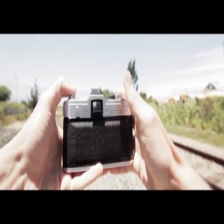

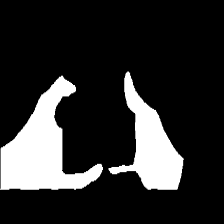

In [21]:
display(Image(filename=color_images_path[4600]))

display(Image(filename=segmented_images_path[4600]))

We cannot afford to load all images in once, therefore we extend Sequence class of keras to load instances as batches of batch_size

### NOTE: 
- Normalization of input is done through BatchNormalization layer in the model

- Here we scale output to [0,1] values and add 1 dimension to match model output layer (img_size, img_size, 1)

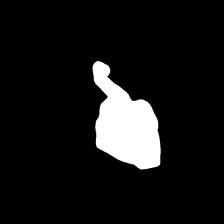

In [22]:
# SOME checks on data type

pathColored = color_images_path[23]
img = load_img(pathColored, target_size=(224,224))
img01 = img_to_array(img)
#print(img_to_array(img).shape)
path = segmented_images_path[23]
img = load_img(path, target_size=(224,224), color_mode="grayscale")
#print(img_to_array(img)[:, 155])
img01 = img_to_array(img).astype('float32')/255
display(array_to_img(img01))
#print(img01.shape)
#print(np.expand_dims(img01, -1).shape)

In order to regularize the model and not overfit on test data we perform 
## Data augmentation 
This is done on the fly during training to not overload dataset size

In [23]:
import albumentations as A
import cv2

# helpful to visualize image
def visualize(image, color=True):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    if color == True:
      plt.imshow(image)
    else:
      plt.imshow(image, cmap='gray')

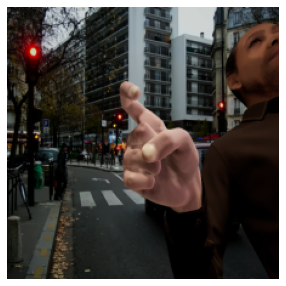

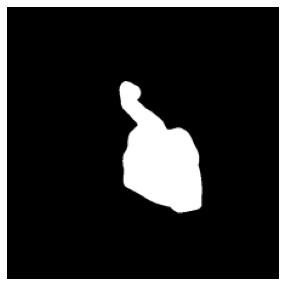

In [24]:
i = 23 # which img to test?
pathColored = color_images_path[i]
pathSegmented = segmented_images_path[i]
imgColor = cv2.imread(pathColored)
# CONVERSION NEEDED as albumentation works in RGB
imgColor = cv2.cvtColor(imgColor, cv2.COLOR_BGR2RGB)
visualize(imgColor)
imgSegmented = cv2.imread(pathSegmented, cv2.IMREAD_GRAYSCALE)
visualize(imgSegmented, False)

def augmentation(p=0.8):
    return A.Compose([
        A.OneOf([
            A.RandomRotate90(p=0.3),
            A.Flip(p=0.3),
            A.Transpose(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.4),
            A.OpticalDistortion(p=0.3),
        ], p=p),
        A.OneOf([
            A.RandomSizedCrop(min_max_height=(150, 150), height=224, width=224, p=0.5),     
        ], p=p),            
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(p=0.7),
            A.RGBShift(p=0.5)
        ], p=p)
    ])

augmentedImg = augmentation(p=0.8)

(224, 224, 3)
(224, 224)


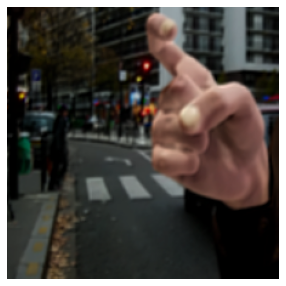

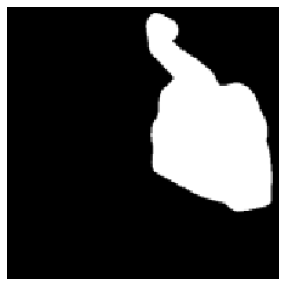

In [25]:
data = {"image": imgColor, "mask": imgSegmented}
augmented = augmentedImg(**data)

color_augmented, seg_augmented = augmented["image"], augmented["mask"]

visualize(color_augmented)
visualize(seg_augmented, False)
print(color_augmented.shape)
print(seg_augmented.shape)

#print(img_to_array(seg_augmented).astype('float32')/255)

Let's extend keras Sequence class to load images by batches of batch_size and perform DataAugmentation on the fly using the above defined function

We have to be careful that:
- we need to apply same augmentation on color and segmented image
- load images using cv
- converting from BGR to RGB
- converting to array when creating batch tensor of instances
- normalize segmented images s.t. output is in 0,1 values spannable by sigmoid 
- not normalize input as will be done in the BatchNormalization Layer in the model

In [26]:
class HandsDataset(keras.utils.Sequence):

  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = color_images_path
    self.target_img_paths = segmented_images_path
    self.augmentedImg = augmentation(p=0.7)

  # total number of batches 
  def __len__(self):
    return len(self.target_img_paths) // self.batch_size 

  def __getitem__(self, idx):
    """Returns tuple (input, target) correspond to batch #idx."""
    i = idx * self.batch_size #compute starting absolute index given current batch number and its dimension
    # paths of the images we have to load
    batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
    batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
    
    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") # tensor in which colored images will be stored
    y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32") # tensor in which segmented images will be stored
    
    for j in range(0, len(batch_input_img_paths)):
      # load color image using cv2 and convert it from BGR to RGB (required by Albumentation)
      imgColor = cv2.imread(batch_input_img_paths[j])
      imgColor = cv2.cvtColor(imgColor, cv2.COLOR_BGR2RGB)
      # load segmented corresponding mask
      imgSegmented = cv2.imread(batch_target_img_paths[j], cv2.IMREAD_GRAYSCALE)

      # Apply augmentation on both
      data = {"image": imgColor, "mask": imgSegmented}
      augmented = self.augmentedImg(**data)
      color_augmented, seg_augmented = augmented["image"], augmented["mask"]

      x[j] = img_to_array(color_augmented)
      y[j] = (img_to_array(seg_augmented)).astype('float32')/255

    return x, y

Defining U-net model

In [27]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
    #for filters in [32, 64, 128]:
    #for filters in [16, 32, 64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.4)(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
    #for filters in [128, 64, 32, 16]:
    #for filters in [64, 32, 16, 8]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)
        

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

Split in train, validation and test

In [28]:
tp = 0.9 # train percentage
nInstances = len(color_images_path)

color_images_path_train, color_images_path_validTest = color_images_path[:int(tp*nInstances)], color_images_path[int(tp*nInstances):]
segmented_images_path_train, segmented_images_path_validTest = segmented_images_path[:int(tp*nInstances)], segmented_images_path[int(tp*nInstances):]

nInstancesVT = len(color_images_path_validTest)
color_images_path_valid, color_images_path_test = color_images_path_validTest[:int(0.5*nInstancesVT)], color_images_path_validTest[int(0.5*nInstancesVT):]
segmented_images_path_valid, segmented_images_path_test = segmented_images_path_validTest[:int(0.5*nInstancesVT)], segmented_images_path_validTest[int(0.5*nInstancesVT):]


# Instantiate data Sequences for each split
train_gen = HandsDataset(batch_size, img_size, color_images_path_train, segmented_images_path_train)
val_gen = HandsDataset(batch_size, img_size, color_images_path_valid, segmented_images_path_valid)

In [29]:
print(len(color_images_path_train))
print(len(segmented_images_path_train))
print(len(color_images_path_valid))
print(len(color_images_path_test))

# checking some random pairs 1 to 1 correspondence
#for c, s in zip(train_gen[0][0][:,1], train_gen[1][:,1]):
    #print(c, "|", s)

7045
7045
391
392


Let's train the model

In [30]:
from keras import backend as K

# Let y_true be the tensor of segmented masks (n,224,224,1) (normalized) and y_pred the tensor of our predictions (n,224,224,1) (normalized)
# Since we work with tensor we cannot use numpy but use backend
def dice_coef(y_true, y_pred, smooth=1):
  # First I need to compute intersection area, but I want only values greater than 0.8 to be considered
  # I subtract from y_pred tensor 0.8 and then apply sign function, but if y_true 1 and y_pred was 0.3 lowers the intersection value (which is good?!)
  # something like y = 0.8 tf.subtract(y_pred, y) and then K.sign()
  intersection = K.sum(y_true * y_pred, axis=[1,2,3]) # compute sum along width, height and channel axis
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0) # Now along all instances
  return dice

In [31]:
# Configure the model for training
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[dice_coef])

# Early stopping
# Let's define a log dir in order to save the checkpoint file
logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),

    #Saving the checkpoints file allows to load the "best" model when the Early 
    #stopping detect that the generalization error degrade (after 'patience' epochs)
    keras.callbacks.ModelCheckpoint("handSegmentationUnet.h5", save_best_only=True),
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/50
122/122 [==============================] - 193s 2s/step - loss: 0.4895 - dice_coef: 0.3317 - val_loss: 0.4705 - val_dice_coef: 0.0809
Epoch 2/50
122/122 [==============================] - 184s 2s/step - loss: 0.2587 - dice_coef: 0.4205 - val_loss: 0.4163 - val_dice_coef: 0.2215
Epoch 3/50
122/122 [==============================] - 182s 1s/step - loss: 0.2233 - dice_coef: 0.4595 - val_loss: 0.4050 - val_dice_coef: 0.2146
Epoch 4/50
122/122 [==============================] - 182s 1s/step - loss: 0.2057 - dice_coef: 0.4870 - val_loss: 0.2540 - val_dice_coef: 0.3481
Epoch 5/50
122/122 [==============================] - 181s 1s/step - loss: 0.1909 - dice_coef: 0.5064 - val_loss: 0.2083 - val_dice_coef: 0.4665
Epoch 6/50
122/122 [==============================] - 181s 1s/step - loss: 0.1830 - dice_coef: 0.5176 - val_loss: 0.2145 - val_dice_coef: 0.4564
Epoch 7/50
122/122 [==============================] - 182s 1s/step - loss: 0.1741 - dice_coef: 0.5301 - val_loss: 0.2006 - val_dic

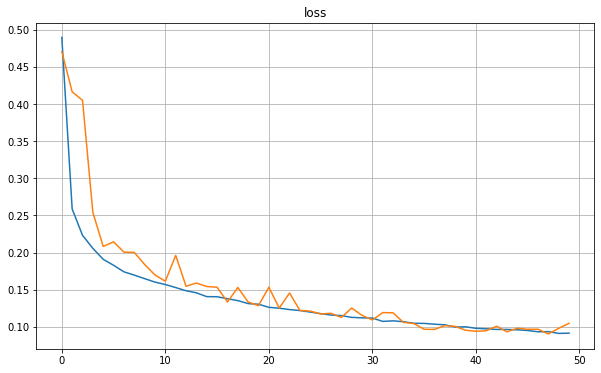

In [32]:
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.grid()
    plt.title('loss')

plot_loss(history)

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['dice_coef'],label='dice_coef')
  plt.plot(history.epoch,history.history['val_dice_coef'],label='val_dice_coef')
  plt.title('dice_coef')
  plt.legend()

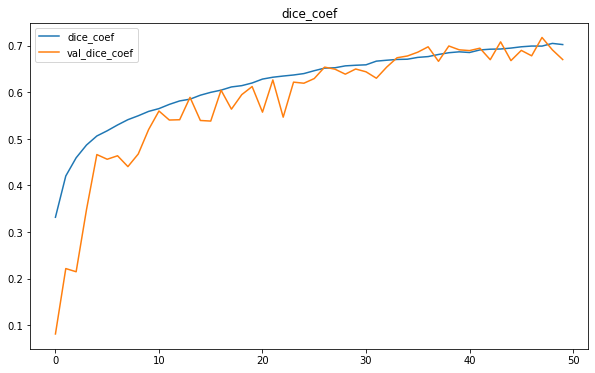

In [33]:
plot_accuracy(history)

In [34]:
model = tf.keras.models.load_model('/content/handSegmentationUnet.h5', compile='false', custom_objects={"dice_coef": dice_coef})

In [35]:
test_gen = HandsDataset(batch_size, img_size, color_images_path_test, segmented_images_path_test)
scores = model.evaluate(test_gen, verbose=2)
print("Test loss score: %.5f" % (scores[0]))
print("Test Dice score: %.5f" % (scores[1]))

122/122 - 89s - loss: 0.0904 - dice_coef: 0.7170 - 89s/epoch - 732ms/step
Test loss score: 0.09043
Test Dice score: 0.71704


In [36]:
test_preds = model.predict(test_gen)

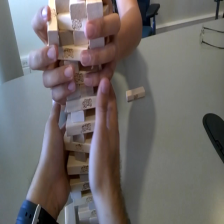

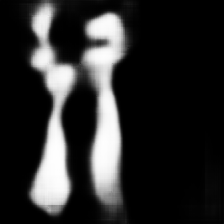

In [37]:
i=50
img = load_img(color_images_path_test[i])
display(img)

prediction = model.predict(img_to_array(img).reshape(1,224,224,3))
display(array_to_img(prediction[0]*255))

In [38]:
model = tf.keras.models.load_model('/content/handSegmentationUnet.h5', compile='true', custom_objects={"dice_coef": dice_coef})

In [39]:
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),

    #Saving the checkpoints file allows to load the "best" model when the Early 
    #stopping detect that the generalization error degrade (after 'patience' epochs)
    keras.callbacks.ModelCheckpoint("handSegmentationUnet.h5", save_best_only=True),
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/10
122/122 [==============================] - 184s 1s/step - loss: 0.0918 - dice_coef: 0.7046 - val_loss: 0.0861 - val_dice_coef: 0.7198
Epoch 2/10
122/122 [==============================] - 182s 1s/step - loss: 0.0926 - dice_coef: 0.7006 - val_loss: 0.0963 - val_dice_coef: 0.6673
Epoch 3/10
122/122 [==============================] - 181s 1s/step - loss: 0.0895 - dice_coef: 0.7049 - val_loss: 0.0871 - val_dice_coef: 0.7043
Epoch 4/10
122/122 [==============================] - 183s 2s/step - loss: 0.0907 - dice_coef: 0.7056 - val_loss: 0.0980 - val_dice_coef: 0.6881
Epoch 5/10
122/122 [==============================] - 183s 1s/step - loss: 0.0903 - dice_coef: 0.7090 - val_loss: 0.0870 - val_dice_coef: 0.7048
Epoch 6/10
122/122 [==============================] - 183s 2s/step - loss: 0.0891 - dice_coef: 0.7092 - val_loss: 0.0830 - val_dice_coef: 0.7282
Epoch 7/10
122/122 [==============================] - 183s 2s/step - loss: 0.0877 - dice_coef: 0.7137 - val_loss: 0.0907 - val_dic

In [40]:
test_gen = HandsDataset(batch_size, img_size, color_images_path_test, segmented_images_path_test)
scores = model.evaluate(test_gen, verbose=2)
print("Test loss score: %.5f" % (scores[0]))
print("Test Dice score: %.5f" % (scores[1]))

122/122 - 82s - loss: 0.0852 - dice_coef: 0.7092 - 82s/epoch - 674ms/step
Test loss score: 0.08523
Test Dice score: 0.70918
